## **"Titulo: Análisis de Características Clínicas y Creación de un Modelo Predictivo para Hospitalización en Pacientes Post Biopsia Prostática"**


### **1. Premisa**
Nuestro cliente desea saber las características más importantes que tienen los pacientes de cierto tipo de enfermedad que terminan en hospitalización.

Fue definido como caso aquel paciente que fue sometido a biopsia prostática, y que en un periodo máximo de 30 días posteriores al procedimiento presentó fiebre, infección urinaria o sepsis, requiriendo manejo médico ambulatorio u hospitalizado para la resolución de la complicación.

Y como control al paciente que fue sometido a biopsia prostática y que no presentó complicaciones infecciosas en el período de 30 días posteriores al procedimiento.

Para ello, nuestro departamento de datos ha recopilado Antecedentes del paciente, Morbilidad asociada al paciente y Antecedentes relacionados con la toma de la biopsiay Complicaciones infecciosas. En la siguiente tabla, se encuentra un diccionario de datos asociado:

![image](https://user-images.githubusercontent.com/118769777/220240501-8c21461d-2de5-495b-954e-10fb9bf38014.png)

El departamento de datos advierte que hay algunos problemas de calidad de datos en la información suministrada

Recuerden que nuestro cliente desea saber las características más importantes que tienen los pacientes de cierto tipo de enfermedad que terminan en hospitalización y crear un modelo predictivo de clasificación para la variable objetivo: Hospitalización.



### **2. Preparación de datos**
Carga de la base de datos y analisis basico del dataframe para determinar la integridad del mismo


In [2]:
# Librerias utilizadas en el documento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import chi2_contingency

df = pd.read_excel('BBDD_Hospitalización.xlsx')
info_dataframe = df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 20 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   EDAD                                                                       568 non-null    float64
 1   DIABETES                                                                   568 non-null    object 
 2   HOSPITALIZACIÓN ULTIMO MES                                                 568 non-null    object 
 3   PSA                                                                        564 non-null    float64
 4   BIOPSIAS PREVIAS                                                           566 non-null    object 
 5   VOLUMEN PROSTATICO                                                         567 non-null    object 
 6   ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                   

d:\Proyectos\Data Science\Hospitales ML\venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
descripcion_dataframe = df.describe(include='all')
print(descripcion_dataframe)


              EDAD DIABETES HOSPITALIZACIÓN ULTIMO MES         PSA  \
count   568.000000      568                        568  564.000000   
unique         NaN        2                          2         NaN   
top            NaN       NO                         NO         NaN   
freq           NaN      505                        563         NaN   
mean     63.882042      NaN                        NaN   13.271401   
std       9.281517      NaN                        NaN   15.668966   
min      39.000000      NaN                        NaN    0.600000   
25%      59.000000      NaN                        NaN    5.600000   
50%      64.000000      NaN                        NaN    8.000000   
75%      69.000000      NaN                        NaN   15.000000   
max     151.000000      NaN                        NaN  100.000000   

       BIOPSIAS PREVIAS VOLUMEN PROSTATICO  \
count               566                567   
unique                2                  2   
top                  

In [4]:
nulos_dataframe = df.isnull().sum()
display(nulos_dataframe)

EDAD                                                                          2
DIABETES                                                                      2
HOSPITALIZACIÓN ULTIMO MES                                                    2
PSA                                                                           6
BIOPSIAS PREVIAS                                                              4
VOLUMEN PROSTATICO                                                            3
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       2
NUMERO DE MUESTRAS TOMADAS                                                    2
CUP                                                                           3
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             4
BIOPSIA                                                                       2
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     2
FIEBRE                                  

### **3. Limpieza de los datos**

#### - 3.1 Eliminacion de Parametros innecesarios o redundantes

In [5]:
# Las siguientes columnas son parametros que se toman cuando ya se encontro la complicacion en el paciente
# por lo que dejarlos ademas de ser redundante puede crear error en el analisis predictivo
eliminar_cols = [ 'NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA','FIEBRE','ITU','TIPO DE CULTIVO','AGENTE AISLADO','PATRON DE RESISTENCIA','DIAS HOSPITALIZACION MQ','DIAS HOSPITALIZACIÓN UPC']
df.drop(eliminar_cols,axis=1,inplace=True)
df.columns


Index(['EDAD', 'DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'PSA',
       'BIOPSIAS PREVIAS', 'VOLUMEN PROSTATICO',
       'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS', 'NUMERO DE MUESTRAS TOMADAS',
       'CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA', 'BIOPSIA',
       'HOSPITALIZACION'],
      dtype='object')

#### - 3.2 Tratamiento de los datos nulos
**3.2.1**
Primero encontramos 3 valores nulos en la variable **objetivo** ademas de 2 filas vacias, por lo que se entiende que no se pueden inputar 
de una manera segura estos valores, por lo que se decide a retirarlos

In [6]:
print(df.shape[0])
df = df.dropna(subset=['HOSPITALIZACION'])
print(df.shape[0])

570
565


**3.2.2** Para las varibles numericas vamos a imputar por la media

In [7]:
mean_psa = round(df.PSA.mean(),2)
df.PSA.fillna(mean_psa,inplace=True)



**3.2.3** Para las varibles booleanas vamos a imputar por la moda de la columna

In [8]:
col_bool_null = ['VOLUMEN PROSTATICO','CUP','BIOPSIAS PREVIAS','ENF. CRONICA PULMONAR OBSTRUCTIVA']

for col in col_bool_null:
    moda_col = df[col].value_counts().idxmax()
    df[col].fillna(moda_col,inplace=True)

df.isnull().sum()

EDAD                                       0
DIABETES                                   0
HOSPITALIZACIÓN ULTIMO MES                 0
PSA                                        0
BIOPSIAS PREVIAS                           0
VOLUMEN PROSTATICO                         0
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS    0
NUMERO DE MUESTRAS TOMADAS                 0
CUP                                        0
ENF. CRONICA PULMONAR OBSTRUCTIVA          0
BIOPSIA                                    0
HOSPITALIZACION                            0
dtype: int64

**3.2.4** Normalizacion de columnas categoricas

In [9]:
# remplazamos para crear correctamente los dummys
rep = {'FLUOROQUINOLONA_AMINOGLICÓSIDO':'FLUOROQUINOLONA_AMINOGLICOSIDO'}
df['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS'] = df['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS'].replace(rep)

df['BIOPSIA'] = df['BIOPSIA'].str.strip()

df['ENF. CRONICA PULMONAR OBSTRUCTIVA'] = df['ENF. CRONICA PULMONAR OBSTRUCTIVA'].replace('SI, EPOC','SI')
df['ENF. CRONICA PULMONAR OBSTRUCTIVA'] = df['ENF. CRONICA PULMONAR OBSTRUCTIVA'].replace('SI, ASMA','SI')

#### - 3.3 Tratamiento de Outliers

**3.3.1** Revision la distribución estadística para el caso de las variables numéricas. 
Utilizaremos los histogramas para esta revision 

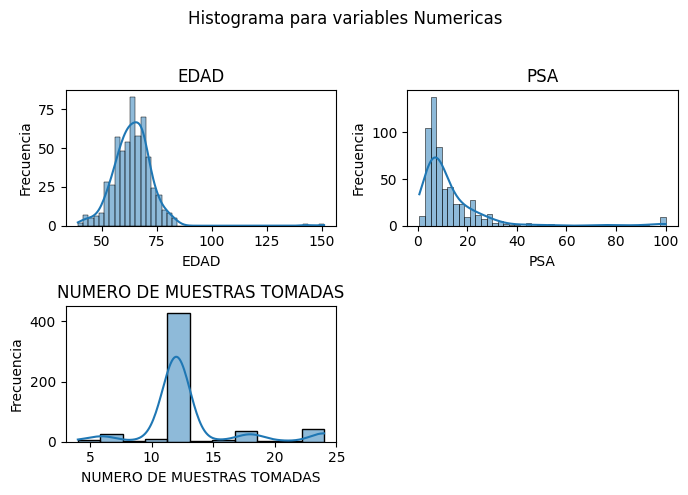

In [10]:
# Function to plot histograms for numerical features
# Funcion para hacer un plot de las variables numericas
def plot_histograms(df):
    numerical_features = ['EDAD', 'PSA', 'NUMERO DE MUESTRAS TOMADAS']
    fig, axes = plt.subplots(2, 2, figsize=(7, 5))
    fig.suptitle('Histograma para variables Numericas')
    axes = axes.flatten()
    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frecuencia')

    # Removing the last empty subplot
    fig.delaxes(axes[-1])
    plt.tight_layout(rect=[0, 0, 1, 0.96])

# Plotting the histograms
plot_histograms(df)
plt.show()

In [11]:
# Se imputaron con la media los datos atipicos de la edad con la media de los datos restantes
media_menor_100 = df[df["EDAD"] < 100]["EDAD"].mean()
print(round(media_menor_100))
df.loc[df["EDAD"] > 100, "EDAD"] = media_menor_100

64


3.3.2 Revision la distribución estadística para el caso de las variables Categoricas. 

C:\Users\octav\AppData\Local\Temp\ipykernel_11608\2436211582.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[10, 10, -5, 0.8])


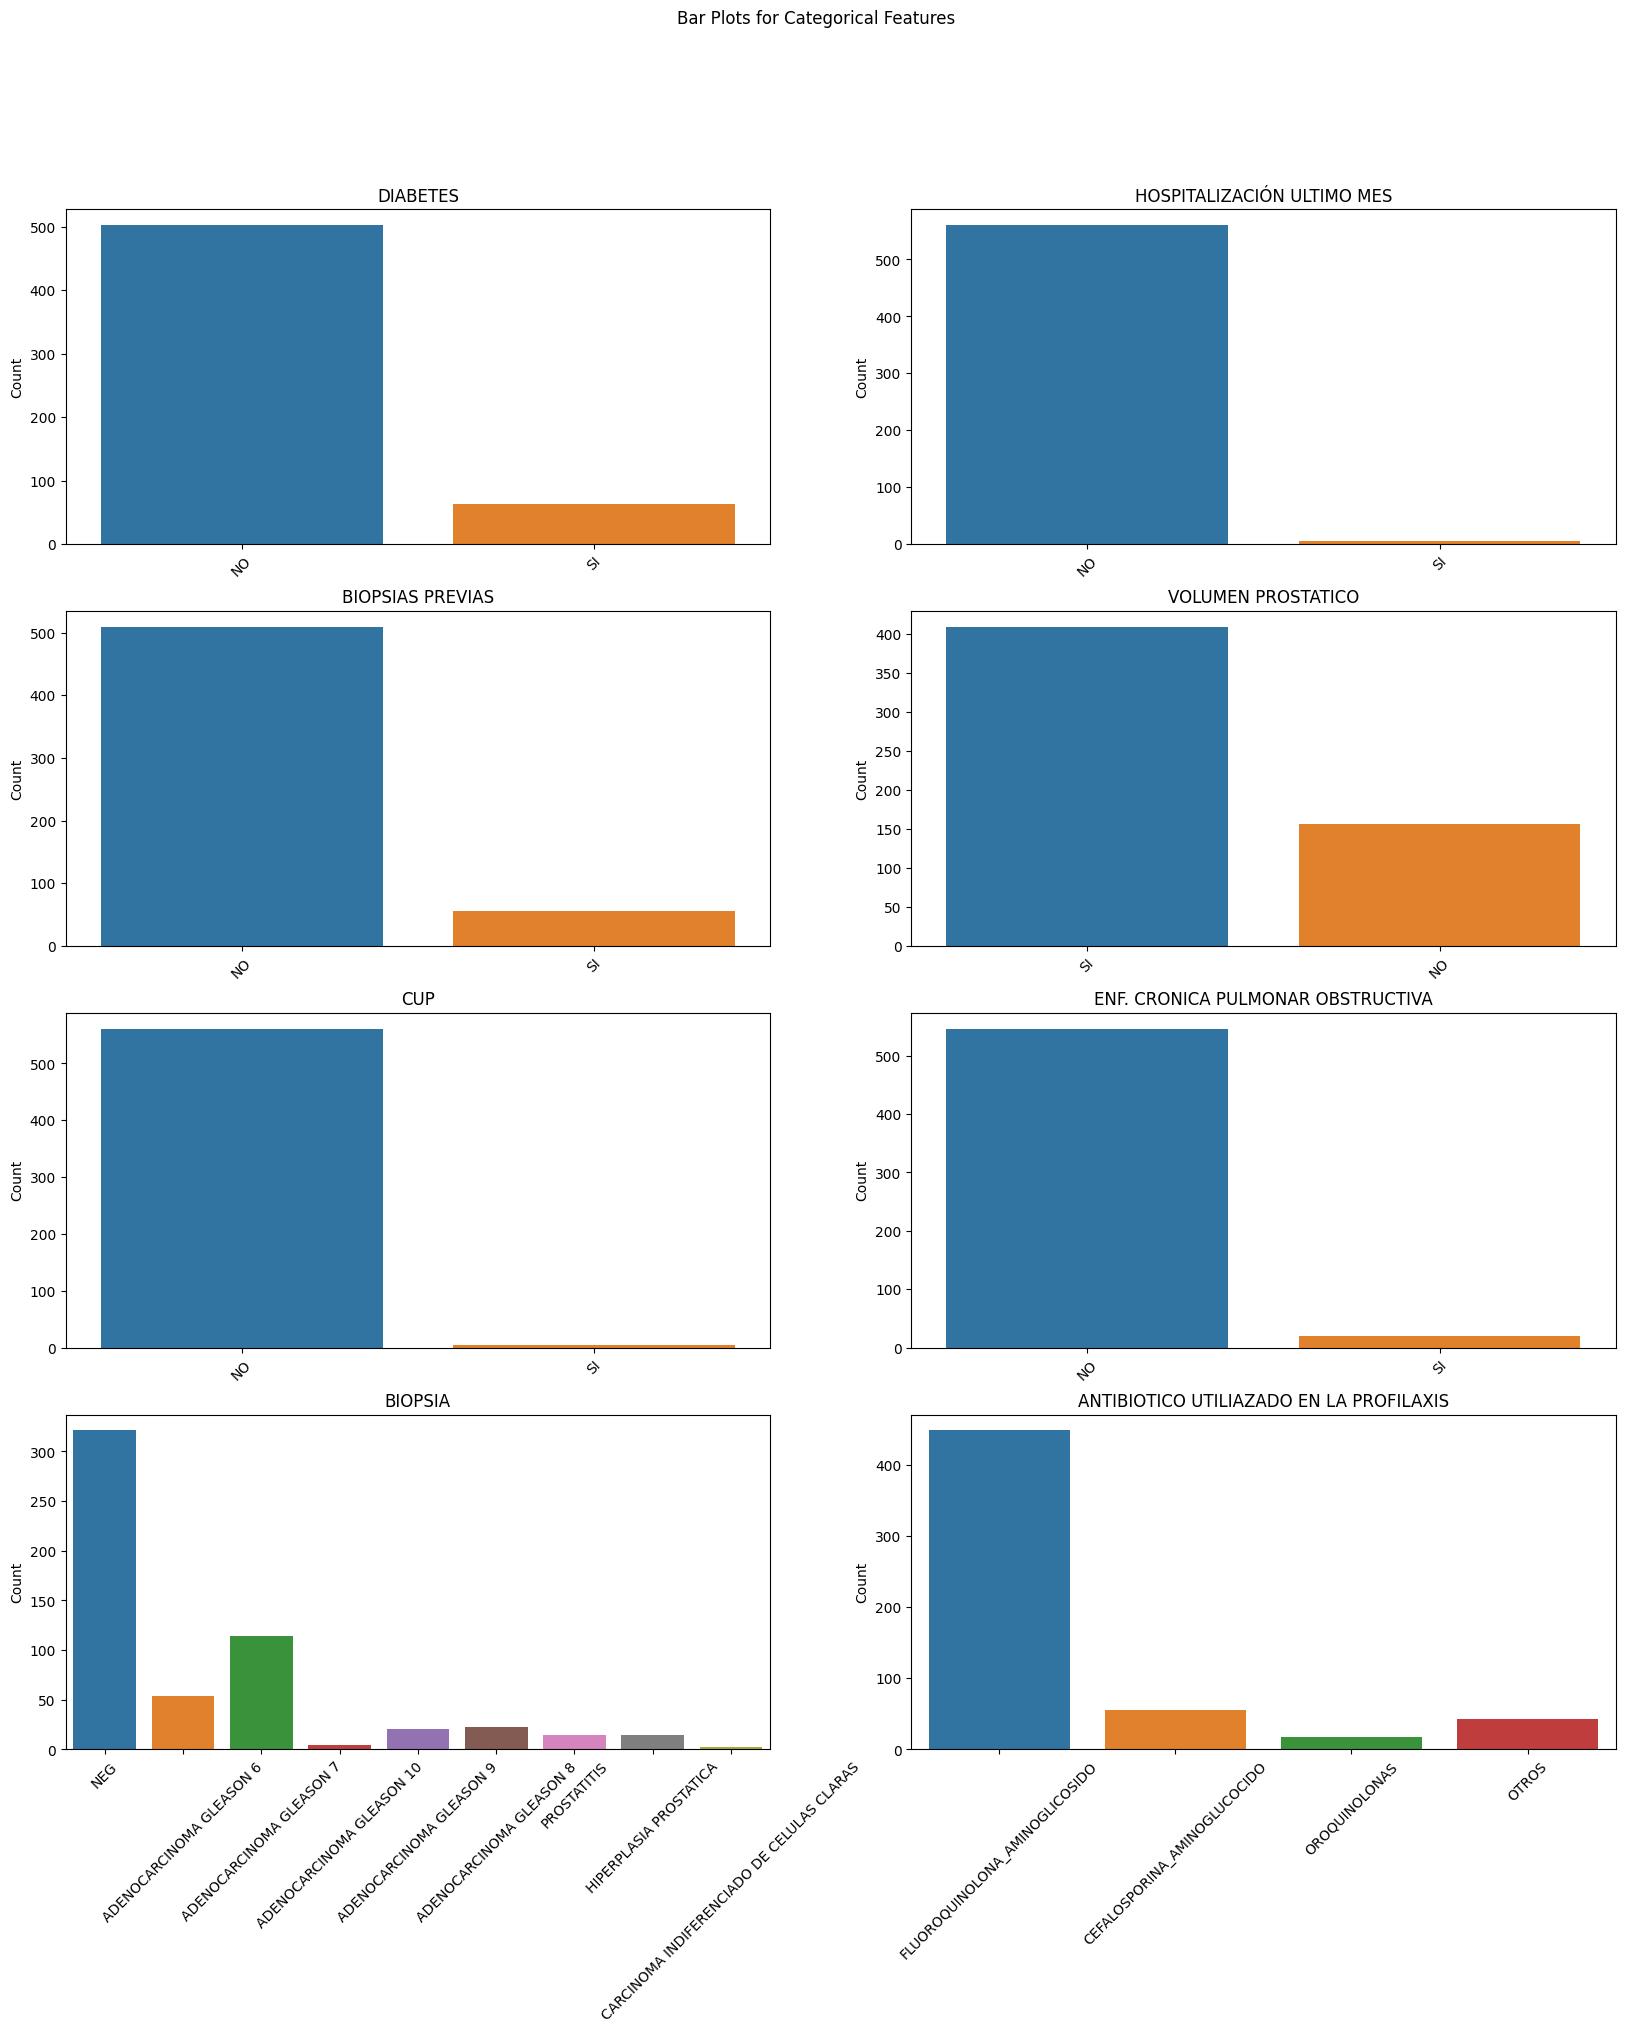

In [12]:
 # Function to plot bar plots for categorical features
def plot_bar_plots(df):
    categorical_features = ['DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'BIOPSIAS PREVIAS',
                            'VOLUMEN PROSTATICO','CUP', 
                            'ENF. CRONICA PULMONAR OBSTRUCTIVA','BIOPSIA' , 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS']
                            
    fig, axes = plt.subplots(4, 2, figsize=(20, 20))
    fig.suptitle('Bar Plots for Categorical Features')
    axes = axes.flatten()
    for i, feature in enumerate(categorical_features):
        sns.countplot(x=df[feature], ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel(None)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[10, 10, -5, 0.8])

# Plotting the bar plots
plot_bar_plots(df)
plt.show()



## 4. Analisis Exploratorio basico

### 4.1 Buscando corelaciones con las variables numericas

d:\Proyectos\Data Science\Hospitales ML\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


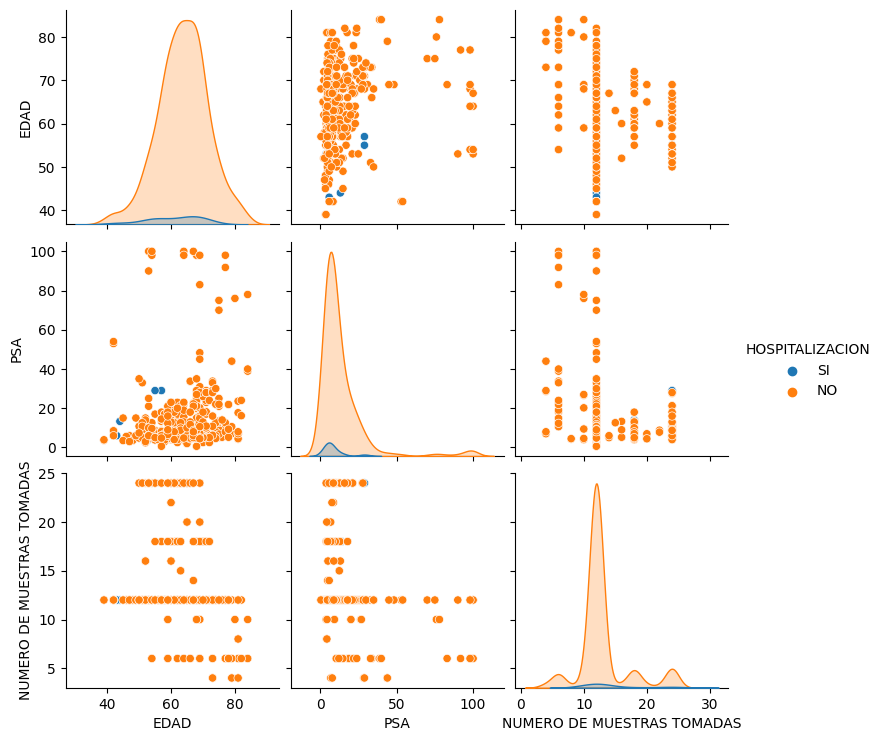

In [13]:
sns.pairplot(df, hue = 'HOSPITALIZACION')
plt.show()

Creamos una matriz de correlaciones para las variables numericas

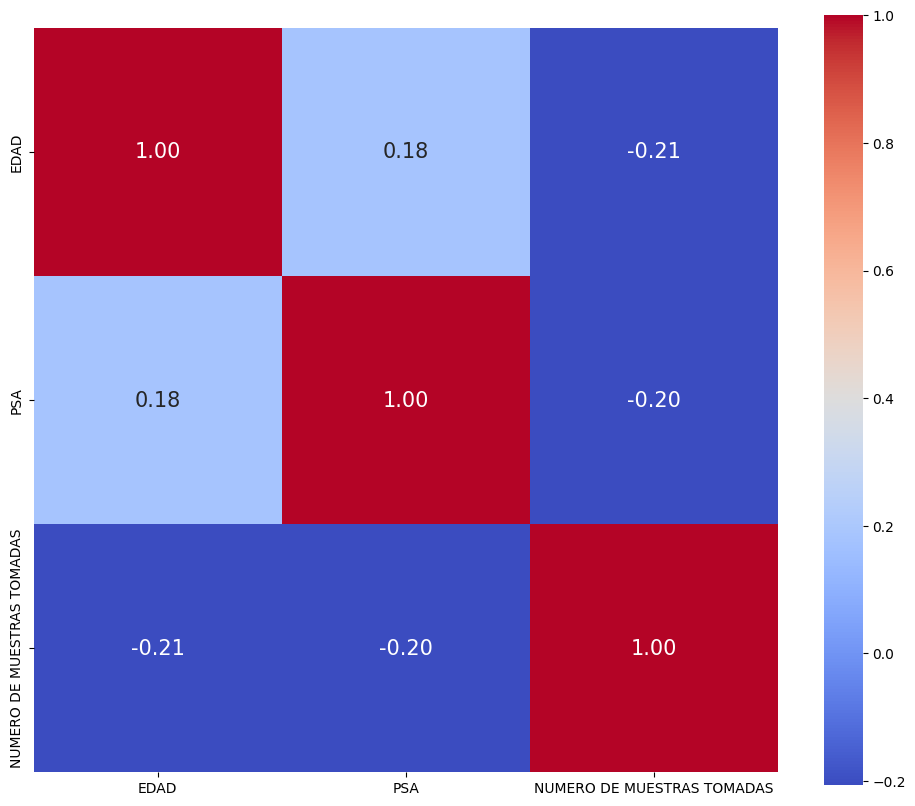

In [14]:
num = ['EDAD', 'PSA', 'NUMERO DE MUESTRAS TOMADAS']
corr = df[num].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= num,
           yticklabels= num,
           cmap= 'coolwarm')
plt.show()

Matriz de corelaciones para las variables Categoricas

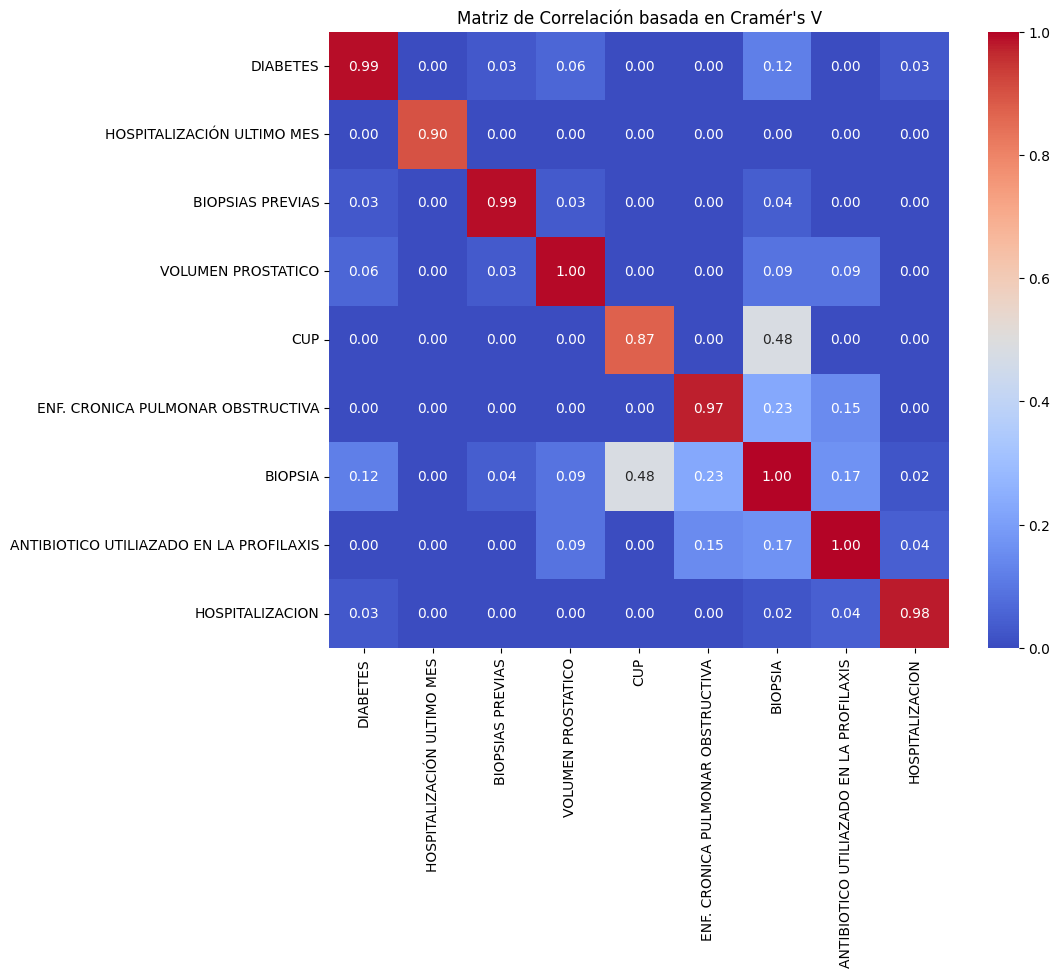

In [15]:
def cramers_v(table):
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    return (phi2corr / min((k_corr - 1), (r_corr - 1)))**0.5

# Columnas binarias y categoricas
columnas = ['DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'BIOPSIAS PREVIAS',
            'VOLUMEN PROSTATICO','CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA',
            'BIOPSIA' , 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS','HOSPITALIZACION']

# Crear una matriz de correlación utilizando el coeficiente de Cramér's V
correlation_matrix = pd.DataFrame(index=columnas, columns=columnas)
for col1 in columnas:
    for col2 in columnas:
        cross_tab = pd.crosstab(df[col1], df[col2])
        correlation_matrix.loc[col1, col2] = cramers_v(cross_tab)

# Convertir los valores a números y mostrar la matriz de correlación como un heatmap
correlation_matrix = correlation_matrix.apply(pd.to_numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación basada en Cramér's V")
plt.show()

## 5 Unificacion de Variables

#### 5.1 Cambio de tipo categorico a tipo binario

In [16]:
reemplazos = {"NO": 0, "SI": 1}
columnas_a_reemplazar  = ['DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'BIOPSIAS PREVIAS',
            'VOLUMEN PROSTATICO','CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA','HOSPITALIZACION']

df[columnas_a_reemplazar] = df[columnas_a_reemplazar].replace(reemplazos)
df.head(3)

EDAD  DIABETES  HOSPITALIZACIÓN ULTIMO MES   PSA  BIOPSIAS PREVIAS  \
0  53.0         0                           0   4.0                 0   
1  56.0         0                           0   7.7                 0   
2  57.0         0                           0  29.0                 1   

   VOLUMEN PROSTATICO ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS  \
0                   1          FLUOROQUINOLONA_AMINOGLICOSIDO   
1                   1          FLUOROQUINOLONA_AMINOGLICOSIDO   
2                   1          FLUOROQUINOLONA_AMINOGLICOSIDO   

   NUMERO DE MUESTRAS TOMADAS  CUP  ENF. CRONICA PULMONAR OBSTRUCTIVA BIOPSIA  \
0                        12.0    0                                  0     NEG   
1                        12.0    0                                  0     NEG   
2                        24.0    0                                  0     NEG   

   HOSPITALIZACION  
0                1  
1                1  
2                1

#### 5.2 Cambio de columnas categoricas a columnas dummy


In [17]:
# crear dummies

columna_categorica = "ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS"
df_dummies = pd.get_dummies(df[columna_categorica], prefix='ANTIBIOTICO USADO')
df_dum = pd.concat([df, df_dummies], axis=1)

columna_categorica2 = "BIOPSIA"
df_dummies2 = pd.get_dummies(df[columna_categorica2], prefix='BIOPSIA')
df_dum = pd.concat([df_dum, df_dummies2], axis=1)

df_dum.drop('ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS',axis=1,inplace=True)
df_dum.drop('BIOPSIA',axis=1,inplace=True)

df_dum

EDAD  DIABETES  HOSPITALIZACIÓN ULTIMO MES    PSA  BIOPSIAS PREVIAS  \
0    53.0         0                           0   4.00                 0   
1    56.0         0                           0   7.70                 0   
2    57.0         0                           0  29.00                 1   
3    56.0         0                           0   7.00                 0   
4    55.0         0                           0  29.00                 1   
..    ...       ...                         ...    ...               ...   
563  67.0         0                           0   6.00                 0   
564  64.0         0                           0   4.80                 0   
565  69.0         0                           0   4.43                 0   
566  67.0         0                           0   8.00                 0   
567  59.0         0                           0   9.00                 1   

     VOLUMEN PROSTATICO  NUMERO DE MUESTRAS TOMADAS  CUP  \
0                     1                        12.0    0   
1                     1                        12.0    0   
2                     1                        24.0    0   
3                     1                        12.0    0   
4                     1                        24.0    0   
..                  ...                         ...  ...   
563                   1                        12.0    0   
564                   1                        12.0    0   
565                   1                        20.0    0   
566                   1                        12.0    0   
567                   1                        12.0    0   

     ENF. CRONICA PULMONAR OBSTRUCTIVA  HOSPITALIZACION  ...  \
0                                    0                1  ...   
1                                    0                1  ...   
2                                    0                1  ...   
3                                    0                1  ...   
4                                    0                1  ...   
..                                 ...              ...  ...   
563                                  0                0  ...   
564                                  0                0  ...   
565                                  0                0  ...   
566                                  0                0  ...   
567                                  0                0  ...   

     ANTIBIOTICO USADO_OTROS  BIOPSIA_ADENOCARCINOMA GLEASON 10  \
0                      False                              False   
1                      False                              False   
2                      False                              False   
3                      False                              False   
4                      False                              False   
..                       ...                                ...   
563                    False                              False   
564                     True                              False   
565                    False                              False   
566                    False                              False   
567                    False                              False   

     BIOPSIA_ADENOCARCINOMA GLEASON 6  BIOPSIA_ADENOCARCINOMA GLEASON 7  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                               False                             False   
4                               False                             False   
..                                ...                               ...   
563                              True                             False   
564                             False                              True   
565                             False                             False   
566                             False          

#### 5.3 Balanceamos el Df con un oversampleo de los valores de hospitalizacion positivos


In [23]:
# balancear multiplicando los valores

# Separar las características y la variable objetivo
X = df_dum.drop('HOSPITALIZACION', axis=1)  # Características
y = df_dum['HOSPITALIZACION']  # Variable objetivo

# Crear el objeto de oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')

# Aplicar el oversampling a las características y la variable objetivo
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Crear un nuevo DataFrame con las características oversampleadas y la variable objetivo
df_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)

df_oversampled.shape[0]

1082

Creamos una matriz de corelacion con el DF oversampleado y con los valores en binario

In [21]:
corr = df_oversampled.corr()
plt.figure(figsize=(100,100))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 45},
           xticklabels= df_oversampled.columns,
           yticklabels= df_oversampled.columns,
           cmap= 'coolwarm')
plt.xticks(rotation=45, ha='right',fontsize=45)
plt.yticks(fontsize=45)


plt.show()

## 6 Exportar DataFrame
Exportamos los datos para tener el archivo listo para el Modelamiento

In [25]:
df_oversampled.to_csv('revision.csv',index=False)


In [26]:
df_oversampled.columns

Index(['EDAD', 'DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'PSA',
       'BIOPSIAS PREVIAS', 'VOLUMEN PROSTATICO', 'NUMERO DE MUESTRAS TOMADAS',
       'CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA',
       'ANTIBIOTICO USADO_CEFALOSPORINA_AMINOGLUCOCIDO',
       'ANTIBIOTICO USADO_FLUOROQUINOLONA_AMINOGLICOSIDO',
       'ANTIBIOTICO USADO_OROQUINOLONAS', 'ANTIBIOTICO USADO_OTROS',
       'BIOPSIA_ADENOCARCINOMA GLEASON 10', 'BIOPSIA_ADENOCARCINOMA GLEASON 6',
       'BIOPSIA_ADENOCARCINOMA GLEASON 7', 'BIOPSIA_ADENOCARCINOMA GLEASON 8',
       'BIOPSIA_ADENOCARCINOMA GLEASON 9',
       'BIOPSIA_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS',
       'BIOPSIA_HIPERPLASIA PROSTATICA', 'BIOPSIA_NEG', 'BIOPSIA_PROSTATITIS',
       'HOSPITALIZACION'],
      dtype='object')